# Ames House Sale Price Data Cleaning and Prediction
Derek Long, 06/05/2021

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as path
sns.set()

import dslab

C:\Users\longd\AppData\Local\conda\conda\envs\term121x_env\python.exe
{'numpy': '1.20.1', 'pandas': '1.1.3', 'seaborn': '0.11.0', 'sklearn': '0.23.2', 'matplotlib': '3.3.1'}


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## 1. Loading data

In [4]:
def split_features_labels(fn='train.csv', target_col=None):
    df = pd.read_csv(path.join('Data',fn), index_col=0)
    if target_col is not None:
        df = df[(df.GrLivArea < 4000) & (df.LotArea < 30000) & (df.WoodDeckSF < 400)] # filter some outliers
        df = df[df['YearRemodAdd'] >= df['YearBuilt']]
        X = df.drop(target_col, axis=1)
        y = df[target_col].copy()
        return X, y
    else:
        return df

# loading in the datasets
train_df, train_df_labels = split_features_labels(target_col='SalePrice')
test_df = split_features_labels('test.csv')
train_df_labels_logged = np.log(train_df_labels)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

## 2. Transformations

### 2.1 Splitting into numerical and categorical features

In [5]:
def clean_split(df):
    '''
    Clean data and split into numeric and categorical features
    '''
    cleaned_df = df.copy()
    
    # create some new features
    binary = ['2ndFlrSF', 'Fireplaces', 'WoodDeckSF', 'GarageArea']
    for f in binary:
        new_colname = 'Has'+f
        cleaned_df[new_colname] = cleaned_df[f].apply(lambda x: 1 if x > 0 else 0)
    cleaned_df['HasRemod'] = cleaned_df['YearRemodAdd'] != cleaned_df['YearBuilt']
    
    cleaned_df['HouseAge'] = cleaned_df['YrSold'] - cleaned_df['YearBuilt']
    cleaned_df['YrsSinceRemod'] = cleaned_df['YrSold'] - cleaned_df['YearRemodAdd']
    
    # create new total square feet feature
    cleaned_df['TotalSF'] = cleaned_df['GrLivArea'] + cleaned_df['TotalBsmtSF']
    
    # remove features with significant missing values, ones that add to another (dependent), ones with low correlation with target
    drop_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', '1stFlrSF', '2ndFlrSF',
                'LowQualFinSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '3SsnPorch', 'MiscVal', 'PoolArea', 'BsmtHalfBath',
                'BsmtFinType2', 'ExterCond', 'ExterQual', 'LandSlope', 'MoSold', 'YrSold', 'Utilities', 'GrLivArea', 'TotalBsmtSF',
                'Exterior1st', 'Exterior2nd', 'MSSubClass', 'MSZoning', 'GarageType', 'LandContour', 'LotConfig', 'MasVnrType',
                'RoofMatl', 'RoofStyle', 'Street', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'GarageYrBlt', 'GarageArea',
                'MasVnrArea', 'Heating', 'HeatingQC', 'HouseStyle', 'SaleType', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd']
    cleaned_df = cleaned_df.drop(drop_cols, axis=1)
    
    # convert numerical features that should be categorical
    numeric_features = cleaned_df.select_dtypes(exclude='object')
    categorical_features = cleaned_df.select_dtypes(include='object')
    return numeric_features, categorical_features

### 2.2 Preprocessing numerical features

In [6]:
def preprocess_num(num_features, num_pipeline, train):    
    if train:
        return pd.DataFrame(num_pipeline.fit_transform(num_features), columns=num_features.columns, index=num_features.index)
    else:
        return pd.DataFrame(num_pipeline.transform(num_features), columns=num_features.columns, index=num_features.index)

### 2.3 Preprocessing categorical features

In [7]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    for c in missing_cols:
        d[c] = 0

def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    d = d[columns]
    return d

def preprocess_cat(cat_features, steps, train):
    if train:
        cat_features = pd.DataFrame(steps[0].fit_transform(cat_features), columns=cat_features.columns,
                                        index=cat_features.index)
        cat1hot = pd.get_dummies(cat_features)
        steps[1] = cat1hot.columns
        return cat1hot
    else:
        cat_features = pd.DataFrame(steps[0].transform(cat_features), columns=cat_features.columns,
                                        index=cat_features.index)
        cat_features = fix_columns(cat_features, steps[1])
        cat1hot = pd.get_dummies(cat_features)
        return cat1hot

### 2.4 Combine features

In [8]:
def combine_features(num_features_transformed, cat_features_1hot):
    return pd.concat([num_features_transformed, cat_features_1hot], axis=1)

### 2.5 Execute preprocessing steps

In [9]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

pd.options.mode.chained_assignment = None  # default='warn'

def preprocessing(df, num_pipeline, cat_pipeline_steps, train=True):
    num_features, cat_features = clean_split(df)
    num_features_transformed = preprocess_num(num_features, num_pipeline, train)
    cat_features_1hot = preprocess_cat(cat_features, cat_pipeline_steps, train)
    return combine_features(num_features_transformed, cat_features_1hot)

num_pipeline = Pipeline([
    ('imputer', KNNImputer(n_neighbors=100, weights='distance')),
    ('std_scaler', StandardScaler()),
])
    
cat_pipeline_steps = [
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    [] # one hot encoding columns
]

new_train_df = preprocessing(train_df, num_pipeline, cat_pipeline_steps)
new_test_df = preprocessing(test_df, num_pipeline, cat_pipeline_steps, train=False)
new_train_df.head()

,LotArea,OverallQual,OverallCond,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,...,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Order,,,,,,,,,,,,,,,,,,,,,
1474,-0.297294,0.678038,-0.518508,1.150248,0.815660,1.233982,0.177841,-0.21426,-0.934559,0.332567,...,1,0,0,1,0,0,0,0,1,0
1860,0.001702,-0.056634,2.188682,-0.803083,0.815660,-0.755441,0.177841,-0.21426,0.656349,0.332567,...,1,0,0,1,0,0,0,0,1,0
1444,0.430696,0.678038,-0.518508,1.150248,0.815660,1.233982,0.177841,-0.21426,0.656349,0.332567,...,1,0,0,1,0,0,0,0,1,0
2858,-0.011298,0.678038,-0.518508,1.150248,-1.024501,-0.755441,0.177841,-0.21426,0.656349,1.671437,...,1,0,0,1,1,0,0,0,0,0
1101,1.213286,1.412711,-0.518508,1.150248,0.815660,1.233982,1.411283,-0.21426,0.656349,1.671437,...,1,0,0,1,0,0,0,0,1,0


## 3. Optimising Hyperparameters

In [76]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RepeatedKFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

np.random.seed(2)
X = new_train_df.to_numpy()
y = train_df_labels_logged.to_numpy()
X_test_unknown = new_test_df.to_numpy()

def cross_validation(X, y, clf, n_splits=10, n_repeats=10):
    
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=346511053)
    rmse = list()
    for train_index, test_index in cv.split(X):
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])
        rmse.append(np.sqrt(mean_squared_error(np.exp(y_pred), np.exp(y[test_index]))))
    return np.mean(rmse), np.std(rmse)

def plot_metrics(X, y, parameter='alpha', parameter_values=np.arange(0.001, 1, 0.1), estimator=ElasticNet(), 
                 n_splits=10, n_repeats=10):
    
    mean_RMSE = {}
    std_RMSE = {}
    for p in parameter_values:
        clf = estimator
        setattr(clf, parameter, p)
        mean, std = cross_validation(X, y, clf, n_splits, n_repeats)
        mean_RMSE[p] = mean
        std_RMSE[p] = std

    _ = plt.errorbar(mean_RMSE.keys(), mean_RMSE.values(), std_RMSE.values())
    plt.xlabel(parameter)
    plt.ylabel('Mean RMSE')

def best_predict(X, y, estimator=ElasticNet(), param_grid={'alpha': np.arange(0.001, 0.1, 0.01)}, 
                 cv=RepeatedKFold(n_splits=10, n_repeats=10), n_jobs=-1, show=True):

    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs,
    )
    grid_search.fit(X, y)
    clf = grid_search.best_estimator_.fit(X, y)
    meanRMSE, stdRMSE = cross_validation(X, y, clf)
    
    if show:
        print(grid_search.best_params_)
        print('Mean RMSE:', meanRMSE, '\nRMSE STD:', stdRMSE)
        
    return clf, meanRMSE, stdRMSE

For each of the following regression algorithms, we will first try out a broad range of parameter values before narrowing down our search to a specific interval and optimising using GridSearchCV.

### 3.1 Elastic Net

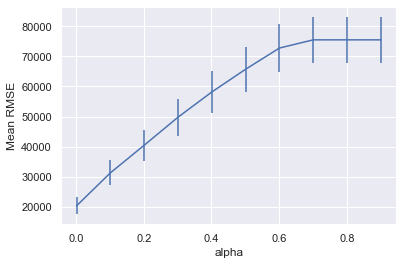

In [64]:
plot_metrics(X, y)

The algorithm seems to perform better for small alpha (essentially ridge regression). We will look at an interval range from 0.01 to 0.1.

In [65]:
clf_ElasticNet, mean, std = best_predict(X, y)

{'alpha': 0.001}
Mean RMSE: 20389.216078628964 
RMSE STD: 2835.2035087047248


### 3.2 Ridge Regression
From optimising the alpha value for Elastic Net, we see that as we get closer to 0, the model performs better. The is essentially performing ridge regression, so we should try it out as our regression algorithm. 

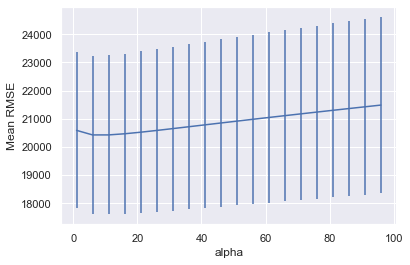

In [93]:
plot_metrics(X, y, parameter_values=np.arange(1, 100, 5), estimator=Ridge())

In [94]:
clf_Ridge, mean, std = best_predict(X, y, estimator=Ridge(), param_grid={'alpha': np.arange(4, 14, 0.1)})

{'alpha': 10.199999999999978}
Mean RMSE: 20421.549114861504 
RMSE STD: 2817.514052950423


### 3.3 Support Vector Machine

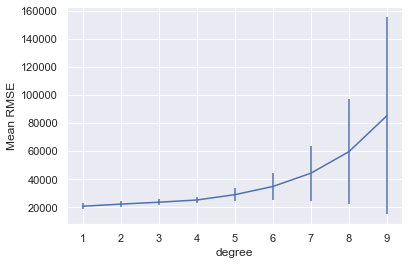

In [83]:
plot_metrics(X, y, parameter='degree', parameter_values=np.arange(1, 10, 1), estimator=SVR(kernel='poly'), 
             n_splits=5, n_repeats=5)

In [88]:
clf_RF, mean, std = best_predict(X, y, estimator=SVR(kernel='poly'), param_grid={'degree': np.arange(1, 6, 1)})

{'degree': 1}
Mean RMSE: 20570.35247135478 
RMSE STD: 2802.40934408597


### 3.4 Predicting with best algorithm

In [105]:
pred_unknown_df = pd.DataFrame(np.exp(clf_Ridge.predict(X_test_unknown)), index=test_df.index)
pred_unknown_df.columns = ['SalePrice']
pred_unknown_df.to_csv('submission.csv')
pred_unknown_df.head()

,SalePrice
Id,
1461,103670.788395
1462,138133.093985
1463,153636.731120
1464,170141.548766
1465,150971.502839
